# Your Average Sentiment Network (AvgNet)

Now, we try different nlp model as given in this paper [1][4], known as Your Average Sentiment Network (AvgNet).

## Data Pre-processing and Preparation

This paper [1,4] calculates the n-grams of an input sentence and append them to the end of a sentence. Here, we'll use bi-grams. Briefly, a bi-gram is a pair of words/tokens that appear consecutively within a sentence. 

For example, in the sentence "how are you ?", the bi-grams are: "how are", "are you" and "you ?".

The `generate_bigrams` function takes a sentence that has already been tokenized, calculates the bi-grams and appends them to the end of the tokenized list.

In [1]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

As an example:

In [2]:
generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']

TorchText `Field`s have a `preprocessing` argument. A function passed here will be applied to a sentence after it has been tokenized (transformed from a string into a list of tokens), but before it has been numericalized (transformed from a list of tokens to a list of indexes). This is where we'll pass our `generate_bigrams` function.

As we aren't using an RNN we can't use packed padded sequences, thus we do not need to set `include_lengths = True`.

In [3]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)
LABEL = data.LabelField(dtype = torch.float)

As before, we load the IMDb dataset and create the splits.

In [4]:
import os
import glob
import io




class IMDB(data.Dataset):
    #aclImdb_v1.tar.gz
    urls = ['/home/usman/Downloads/aclImdb_v1.tar.gz']
    name = 'imdb'
    dirname = 'aclImdb'

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
        """Create an IMDB dataset instance given a path and fields.
        Arguments:
            path: Path to the dataset's highest level directory
            text_field: The field that will be used for text data.
            label_field: The field that will be used for label data.
            Remaining keyword arguments: Passed to the constructor of
                data.Dataset.
        """
        #path=path.replace('data/imdb','')
        
        #print(path)
        ##print(path.replace('data/imdb',''))
        #tttttt
        fname_data = data.RawField()
        
        fields = [('text', text_field), ('label', label_field), ('aname', fname_data)]
        examples = []
        
        #dddddddddd
        for label in ['pos', 'neg']:
            #print(os.path.join(path, label, '*.txt'))
            for fname in glob.iglob(os.path.join(path, label, '*.txt')):
                with io.open(fname, 'r', encoding="utf-8") as f:
                    text = f.readline()
                ##print(fname)
                ##print(text)
                
                examples.append(data.Example.fromlist([text, label,fname.split('aclImdb')[1]], fields))
                #print(examples[0].fname)
                ##mmmmmmmmmmmmm

        super(IMDB, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        """Create dataset objects for splits of the IMDB dataset.
        Arguments:
            text_field: The field that will be used for the sentence.
            label_field: The field that will be used for label data.
            root: Root dataset storage directory. Default is '.data'.
            train: The directory that contains the training examples
            test: The directory that contains the test examples
            Remaining keyword arguments: Passed to the splits method of
                Dataset.
        """
        
        return super(IMDB, cls).splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        """Create iterator objects for splits of the IMDB dataset.
        Arguments:
            batch_size: Batch_size
            device: Device to create batches on. Use - 1 for CPU and None for
                the currently active GPU device.
            root: The root directory that contains the imdb dataset subdirectory
            vectors: one of the available pretrained vectors or a list with each
                element one of the available pretrained vectors (see Vocab.load_vectors)
            Remaining keyword arguments: Passed to the splits method.
        """
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)
        
        #usman123
        train, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)
        #yyyyyyyy
        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)
    
import random

train_data, test_data = IMDB.splits(TEXT, LABEL)
print(len(train_data))

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

25000


Build the vocab and load the pre-trained word embeddings.

In [5]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

And create the iterators.

## Designing the deep NLP Model

Next, we define the deep NLP model as given in the paper ().

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class NLPModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

Next, we make the instance of our NLPModel1 class.

In [10]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = NLPModel1(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

Looking at the number of parameters in our model:

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ',str(count_parameters(model)),'trainable parameters')

The model has  2500301 trainable parameters


And copy the pre-trained vectors to our embedding layer.

In [13]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5302, -1.1032, -1.2348,  ..., -2.4893,  0.0544,  1.7201],
        [-0.4486,  0.8163, -2.6075,  ...,  0.0970, -0.6294, -1.7405],
        [-1.5190, -0.6310, -0.3569,  ...,  0.7558, -1.7540, -1.1697]])

Not forgetting to zero the initial weights of our unknown and padding tokens.

In [14]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## NLP Model Training Process

In [15]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

We define the criterion and place the model and criterion on the GPU (if available)...

In [16]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [17]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...



In [18]:
train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    #batch = next(iterator.__iter__())
    #print(batch.text)
    #print(batch.aname)
    #print(batch.text)
    #usman: check eval
    
    for batch in iterator:
            
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
#        train_loss_values.append(loss.item())
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    #sssssssss
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            #sssdsdssd
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            #valid_loss_values.append(loss.item())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion):
    
    
    import csv

    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    
    g=0
    model.eval()
    #sssssssss
    with torch.no_grad():
    
        for batch in iterator:
            g=g+1
            predictions = model(batch.text).squeeze(1)
            rounded_preds_us = torch.round(torch.sigmoid(predictions))

            epoch_prec+=precision_score(batch.label, rounded_preds_us, average='weighted')  
            epoch_recall+=recall_score(batch.label, rounded_preds_us, average='weighted')  

            #precision_score(y_true, y_pred, average='micro')  

            #precision_score(y_true, y_pred, average='weighted')
            
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            #print(epoch_prec)
            #print(rounded_preds_us)
            #usman:check valid later
            
            with open('sentiment_results_model1_reviews.csv', mode='a') as sent_file:
                file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                
                for x in range(0,len(predictions)):
                    file_writer.writerow([batch.aname[x], rounded_preds_us[x].item(),batch.label[x].item()])

            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    #print('g=',str(g)) 
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_recall / len(iterator)

As before, we'll implement a useful function to tell us how long an epoch takes.

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

In [21]:
N_EPOCHS = 50

train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)
    
    train_acc_values.append(train_acc)
    valid_acc_values.append(valid_acc)
      
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Model1Reviews.pt')
    
    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 1 m  19 s
	Train Loss:  0.6876288652420044  | Train Acc:  61.10694734719549 %
	 Val. Loss:  0.6411755615371769  |  Val. Acc:  66.86528956486006 %
Epoch:  2  | Epoch Time: 1 m  15 s
	Train Loss:  0.6490052912357079  | Train Acc:  75.35600233687101 %
	 Val. Loss:  0.5052165717391645  |  Val. Acc:  76.70815677966102 %
Epoch:  3  | Epoch Time: 1 m  9 s
	Train Loss:  0.5750863539041394  | Train Acc:  80.13392856521328 %
	 Val. Loss:  0.4219299359089237  |  Val. Acc:  80.85275423728814 %
Epoch:  4  | Epoch Time: 1 m  10 s
	Train Loss:  0.49794048516854755  | Train Acc:  84.47031413551665 %
	 Val. Loss:  0.38523436097775476  |  Val. Acc:  83.56726694915254 %
Epoch:  5  | Epoch Time: 1 m  10 s
	Train Loss:  0.43150167852422616  | Train Acc:  87.22301876022868 %
	 Val. Loss:  0.3765268887124829  |  Val. Acc:  85.35487288135593 %
Epoch:  6  | Epoch Time: 1 m  10 s
	Train Loss:  0.3795466052137152  | Train Acc:  88.96474192177293 %
	 Val. Loss:  0.3837648714119095  |  Val

Epoch:  49  | Epoch Time: 1 m  14 s
	Train Loss:  0.014619261433411199  | Train Acc:  99.93156934306569 %
	 Val. Loss:  1.2966420337305231  |  Val. Acc:  89.19050142926685 %
Epoch:  50  | Epoch Time: 1 m  17 s
	Train Loss:  0.013726287712827393  | Train Acc:  99.9543795620438 %
	 Val. Loss:  1.3240555921348476  |  Val. Acc:  89.08456922587702 %


In [22]:
print(len(train_loss_values))
print(len(valid_loss_values))
print(train_loss_values)
print(valid_loss_values)

print(len(train_acc_values))
print(len(valid_acc_values))
print(train_acc_values)
print(valid_acc_values)

with open('the_model1_performance.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_acc_values])
    filehandle.write(tLoss)
    
    
    #for listitem in train_loss_values:
     #   filehandle.write(listitem)




50
50
[0.6876288652420044, 0.6490052912357079, 0.5750863539041394, 0.49794048516854755, 0.43150167852422616, 0.3795466052137152, 0.3409673539500167, 0.3084566519752036, 0.2830022556612091, 0.26241926533462356, 0.24278918011997738, 0.22593317893299744, 0.2118985698877895, 0.19916800099567775, 0.18733462808232237, 0.17423293916304616, 0.16512509957499746, 0.15525692025621007, 0.14460566089264232, 0.13788192901406846, 0.12747656514555433, 0.12136362064765753, 0.11331737084980428, 0.1045981514655108, 0.09963298924131332, 0.0928097023920965, 0.08667936669934513, 0.08112661198570129, 0.07567095373804769, 0.07040829812414455, 0.06496383635204857, 0.05996000694185767, 0.057232439167879144, 0.052567383356011695, 0.048967614868506246, 0.04543049929214873, 0.04143522865220524, 0.038713670483566005, 0.035257538110969495, 0.03263415878614832, 0.03017494995333934, 0.027705225422230625, 0.025375080925419274, 0.02356828139783869, 0.021223676155566026, 0.01997717856438015, 0.01838609909113619, 0.016328

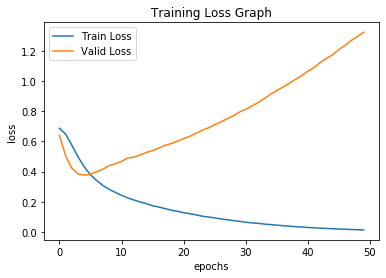

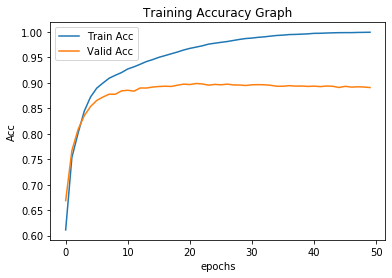

In [23]:
from matplotlib import pyplot as plt


train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]


# open file and read the content in a list
with open('the_model1_performance.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()
    
    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    valid_loss_values=[float(i) for i in filecontents[1].split(',')]
    train_acc_values=[float(i) for i in filecontents[2].split(',')]
    valid_acc_values=[float(i) for i in filecontents[3].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.plot(valid_loss_values,label='Valid Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.plot(valid_acc_values,label='Valid Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


...and get the test accuracy!

The results are comparable to the results in the last notebook, but training takes considerably less time!

In [24]:
model.load_state_dict(torch.load('Model1Reviews.pt'))

import csv

with open('sentiment_results_model1_reviews.csv', mode='w') as sent_file:
    file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    file_writer.writerow(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'])                
    




test_loss, test_acc, test_prec, test_recall = evaluate_test(model, test_iterator, criterion)

print('Test Loss: ',str(test_loss),' | Acc:',str(test_acc*100),'% ', 'Precision: ',str(test_prec), 'Recall: ',str(test_recall))
print('Results are also written in the csv file')

Test Loss:  0.37531749385854474  | Acc: 85.67695012482841 %  Precision:  0.8613734581840713 Recall:  0.8567695012787724
Results are also written in the csv file


**Now generating word cloud.**

Index(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'], dtype='object')


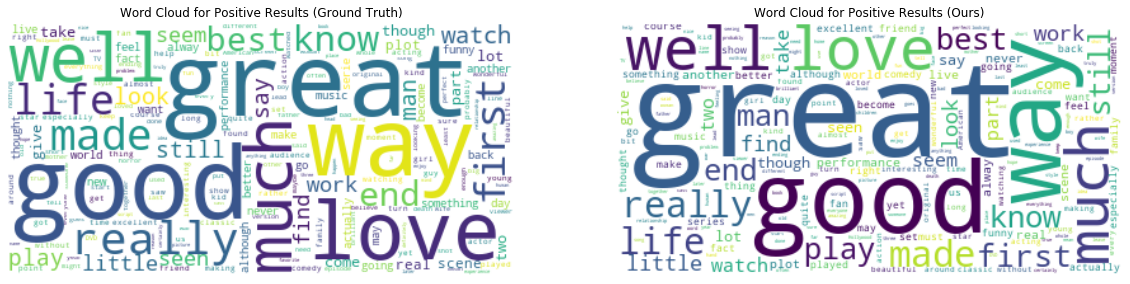

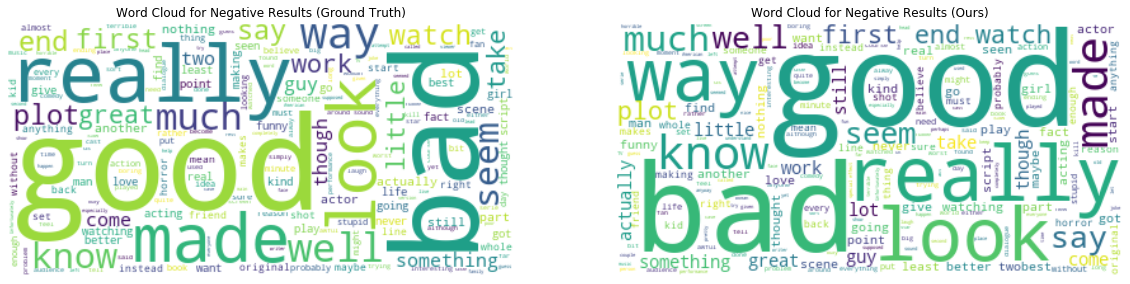

In [25]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='/home/usman/Downloads/aclImdb'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("./sentiment_results_model1_reviews.csv")

allTextPos=""
allTextPosGT=""

print(model_df.columns)

for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==1.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPosGT=allTextPosGT+" "+data

for ind in model_df[model_df['Our Prediction']==1.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPos=allTextPos+" "+data

        

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




allTextNeg=""
allTextNegGT=""

for ind in model_df[model_df['Our Prediction']==0.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         allTextNeg=allTextNeg+" "+data


for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==0.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextNegGT=allTextNegGT+" "+data


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




## References

[1] https://arxiv.org/pdf/1607.01759.pdf

[2] https://arxiv.org/pdf/1408.5882.pdf

[3] https://ai.stanford.edu/~amaas/data/sentiment/

[4] https://github.com/bentrevett/pytorch-sentiment-analysis

[5] https://github.com/tlkh/text-emotion-classification